In [ ]:
import jax
from jax import numpy as jnp
from jax import random
from jaxopt import ProjectedGradient
from jaxopt.projection import projection_hyperplane

# generate metrix [[0, b, ba, ba^2, ..., ba^H-1], [0,0,b,ba, ..., ba^H-2], ...]
def generate_matrix(a, b, H):
    matrix = jnp.zeros((H+1, H))
    for i in range(1, H+1):
        for j in range(0, i):
            # matrix = jax.ops.index_update(matrix, jax.ops.index[i, j], b * a ** (j - i))
            matrix = matrix.at[i, j].set(b * a ** (i -1 - j))
    return matrix

def get_sigma_eign(eign_values, lam, H, sig):
    # Objective function
    def objective(params):
        return jnp.sum(eign_values/(1+2/lam*eign_values*jnp.exp(params))**2)

    # Constraint: x1 + x2 = 1, represented as a hyperplane
    def projection_fn(params, hyperparams_proj):
        return projection_hyperplane(params, hyperparams=(hyperparams_proj, H*jnp.log(sig)))

    # Initialize 'ProjectedGradient' solver
    solver = ProjectedGradient(fun=objective, projection=projection_fn)

    # Initial parameters
    params_init = jnp.zeros(H)

    # Define the optimization problem
    sol = solver.run(params_init, hyperparams_proj=jnp.ones(H))

    # Print the optimal solution
    print("Optimal Solution: ", sol)

    # check if the solution is feasible
    o=eign_values
    s=jnp.exp(sol.params)
    cc = ((o**2)*s)/((1+2/lam*o*s)**3)
    print('cc', cc)

    return jnp.exp(sol.params)

def test_once(H = 3, sig = 0.5, lam = 0.01):
    N=8192
    AB_matrix = generate_matrix(1.0, 1.0, H)
    Q_matrix = jnp.eye(H+1) * 1.0

    a_cov = jnp.eye(H)*sig

    R = AB_matrix.T @ Q_matrix @ AB_matrix
    u, s, vh = jnp.linalg.svd(R)
    sigma_eign = get_sigma_eign(s, lam, H, sig)
    a_cov = vh.T @ jnp.diag(sigma_eign) @ vh

    # a_cov = jnp.linalg.inv(2/lam*R)
    print(s)
    print(R)
    print(a_cov)
    print(jnp.linalg.det(a_cov))

    def dynamic_fn(x, action):
        # x = jnp.clip(0.9*x + 0.4 * jnp.clip(action, -1.0, 1.0), -2, 2)
        x = 1.0*x + action
        return x
    
    def reward_fn(t, x):
        x_tar = jnp.sin(0.6*t)
        reward = 1.0-jnp.abs(x - x_tar)
        return reward

    def get_next_a_mean(t, x, a_mean, rng):
        # shift a_mean to the left by 1 and append the last element
        a_mean = jnp.concatenate([a_mean[1:], a_mean[-1:]])

        rng_act, rng = random.split(rng)
        # sample actions with a_mean and a_cov
        a_sampled = jax.vmap(lambda rng: random.multivariate_normal(rng, a_mean, a_cov))(random.split(rng, N)) # (N, H)

        def rollout_fn(carry, action):
            t, x = carry
            x = dynamic_fn(x, action)
            t = t + 1
            reward = reward_fn(t, x)
            return (t, x), reward

        xx = jnp.repeat(x, N)
        tt = jnp.repeat(t, N)
        _, reward = jax.lax.scan(rollout_fn, (tt, xx), a_sampled.T)

        cost = -jnp.sum(reward, axis=0)
        cost_exp = jnp.exp(-(cost-jnp.min(cost)) / lam)
        weight = cost_exp / jnp.sum(cost_exp)

        a_mean = jnp.sum(a_sampled * weight[:, None], axis=0)

        return a_mean, rng

    def step_env(carry, unused):
        t, x, a_mean, rng = carry
        a_mean, rng = get_next_a_mean(t, x, a_mean, rng)
        action = a_mean[0]
        reward = reward_fn(t, x)
        x = dynamic_fn(x, action)
        t = t + 1
        return (t, x, a_mean, rng), (x, reward)


    def run_exp_once(rng):
        x0 = 1.0
        t0 = 0
        a_mean = jnp.zeros(H)
        carry = (t0, x0, a_mean, rng)
        _, (x, reward) = jax.lax.scan(step_env, carry, jnp.arange(30))
        return reward.mean()

    rng = random.PRNGKey(0)
    # run experiment for 4096 times
    rewards = jax.vmap(jax.jit(run_exp_once))(random.split(rng, 4096))

    return rewards.mean(), rewards.std()

In [ ]:
test_once(H=3)

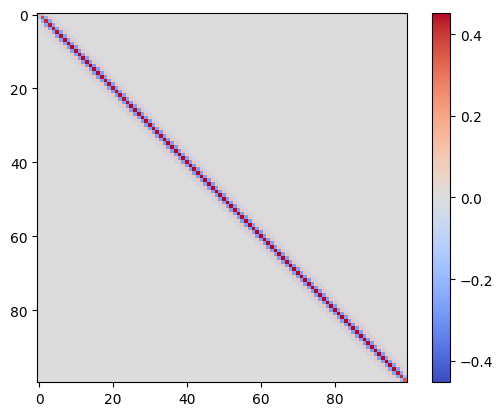

In [22]:
from jax import numpy as jnp

def generate_matrix(a, b, H):
    matrix = jnp.zeros((H+1, H))
    for i in range(1, H+1):
        for j in range(0, i):
            # matrix = jax.ops.index_update(matrix, jax.ops.index[i, j], b * a ** (j - i))
            matrix = matrix.at[i, j].set(b * a ** (i -1 - j))
    return matrix

a, b, q, r = 1.0, 1.0, 1.0, 1.0
H = 100
sigma = 0.5

AB_matrix = generate_matrix(1.0, 1.0, H)
Q_matrix = jnp.eye(H+1) * q
R_matrix = jnp.eye(H) * r

R = AB_matrix.T @ Q_matrix @ AB_matrix + R_matrix

def get_sigma_from_R(R: jnp.ndarray, sigma, H):
    R = (R + R.T)/2.0
    eigns, u = jnp.linalg.eigh(R)
    min_eign = jnp.min(eigns)
    offset = -min_eign + 1e-2
    eigns = eigns + offset
    log_o = jnp.log(eigns)
    element_num = H
    log_det_a_cov = element_num * (jnp.log(sigma)*2)
    log_const = (log_det_a_cov * 2 + jnp.sum(log_o)) / element_num
    log_s = 0.5 * (log_const - log_o)
    a_cov = u @ jnp.diag(jnp.exp(log_s)) @ u.T
    return (a_cov + a_cov.T) / 2.0

a_cov = get_sigma_from_R(R, sigma, H)

from matplotlib import pyplot as plt
max_abs = jnp.max(jnp.abs(a_cov))
plt.imshow(a_cov, cmap="coolwarm", vmin=-max_abs, vmax=max_abs)
# plt.imshow(a_cov - jnp.eye(H)*sigma**2, cmap="coolwarm")
plt.colorbar()